# Fine-tune BLIP using Hugging Face `transformers`, `datasets`, `peft` 🤗 and `bitsandbytes`

Let's leverage recent advances from Parameter Efficient Fine-Tuning methods to fine-tune a large image to text model! We will show through this tutorial that it is possible to fine-tune a 3B scale model (~6GB in half-precision)

Here we will use a dummy dataset of [football players](https://huggingface.co/datasets/ybelkada/football-dataset) ⚽ that is uploaded on the Hub. The images have been manually selected together with the captions. 
Check the 🤗 [documentation](https://huggingface.co/docs/datasets/image_dataset) on how to create and upload your own image-text dataset.

## Set-up environment

In [1]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 102.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 MB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 45.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 2

## Load the image captioning dataset

Let's load the image captioning dataset, you just need few lines of code for that.

In [11]:
import yaml
from easy_vqa import get_answers
from utils import load_config
from dataset_configs.easy_vqa import load_data

def load_config(experiment_id):
    
    def none_constructor(loader, node):
        return None

    # Register the custom constructor for empty strings
    yaml.add_constructor('tag:yaml.org,2002:null', none_constructor)
    with open(f"experiments/{experiment_id}", 'r') as file:
        config = yaml.safe_load(file)
    return config.values()


dataset_config, model_config, wandb = load_config('experiment1_blip2.yaml')



dataset_config.update({'load_fn': load_data}) 
answer_space = get_answers()

#metrics = [ AccuracyMetric(), F1ScoreMetric(), WUPMeasure(answer_space), BertScoreMetric() ]


In [12]:
from datasets import load_dataset 
from utils import load_config
from qadataset import QADataset


dataset = QADataset(dataset_config, split="train[:6]")

Map:   0%|          | 0/38575 [00:00<?, ? examples/s]

Let's retrieve the caption of the first example:

In [14]:
dataset[0][1]['question']

'what is the blue shape?'

And the corresponding image

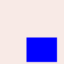

In [15]:
dataset[0][0]

## Create PyTorch Dataset

Let's define below the dataset as well as the data collator!

In [24]:
from torch.utils.data import Dataset, DataLoader

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        encoding = self.processor(images=item[0], padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        question = item[1]['question']
        encoding["question"] = f"Question: {question} Answer: {item[1]['answer']}"
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "question":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["question"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load model and processor

In [17]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

Next we define our `LoraConfig` object. We explicitly tell 

In [18]:
from peft import LoraConfig, get_peft_model

# Let's define the LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.1398


Now that we have loaded the processor, let's load the dataset and the dataloader:

In [25]:
train_dataset = ImageCaptioningDataset(dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=3, collate_fn=collate_fn)

## Train the model

Let's train the model! Run the simply the cell below for training the model

In [26]:
import torch

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"

model.train()

for epoch in range(200):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)
    
    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Epoch: 0
Loss: 1.439453125
Loss: 1.7451171875
Epoch: 1
Loss: 1.482421875
Loss: 0.9306640625
Epoch: 2
Loss: 1.3154296875
Loss: 0.8486328125
Epoch: 3
Loss: 0.943359375
Loss: 0.6767578125
Epoch: 4
Loss: 0.7099609375
Loss: 0.76220703125
Epoch: 5
Loss: 0.35009765625
Loss: 0.74462890625
Epoch: 6
Loss: 0.9150390625
Loss: 0.5986328125
Epoch: 7
Loss: 0.583984375
Loss: 0.896484375
Epoch: 8
Loss: 0.701171875
Loss: 0.759765625
Epoch: 9
Loss: 0.56103515625
Loss: 0.74462890625
Epoch: 10
Loss: 0.46142578125
Loss: 0.5234375
Epoch: 11
Loss: 0.56494140625
Loss: 0.66943359375
Epoch: 12
Loss: 0.48974609375
Loss: 0.6435546875
Epoch: 13
Loss: 0.6708984375
Loss: 0.5
Epoch: 14
Loss: 0.3525390625
Loss: 0.5703125
Epoch: 15
Loss: 0.442138671875
Loss: 0.60595703125
Epoch: 16
Loss: 0.529296875
Loss: 0.48779296875
Epoch: 17
Loss: 0.43310546875
Loss: 0.5380859375
Epoch: 18
Loss: 0.360595703125
Loss: 0.495361328125
Epoch: 19
Loss: 0.370361328125
Loss: 0.486083984375
Epoch: 20
Loss: 0.368408203125
Loss: 0.443359375
Ep

## Inference

Let's check the results on our train dataset

is there a triangle in the image?


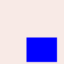

In [78]:
# load image
example = dataset[3]
image = example[0]

text_inputs = processor.tokenizer(
    example[1]["question"], padding=True, return_tensors="pt"
)
question = example[1]['question']

text = f"Question: {question} Answer:"
print(question)
image

In [79]:
# prepare image for the model
inputs = processor(images=image, text=text, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

# generated_ids = model.generate(pixel_values, max_length=25)
generated_ids = model.generate(**inputs, max_length=25)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

 blue


## Push to Hub

In [11]:
from huggingface_hub import notebook_login

notebook_login()

In [14]:
model.push_to_hub("ybelkada/blip2-opt-2.7b-football-captions-adapters")

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/ybelkada/blip2-opt-2.7b-football-captions-adapters/commit/94febcd3b3278e1dbd3d72f7902b03fedeb4bede', commit_message='Upload model', commit_description='', oid='94febcd3b3278e1dbd3d72f7902b03fedeb4bede', pr_url=None, pr_revision=None, pr_num=None)

## Load from the Hub

Once trained you can push the model and processor on the Hub to use them later. 
Meanwhile you can play with the model that we have fine-tuned!
Please restart the runtime to run the cell below!

In [12]:
from transformers import Blip2ForConditionalGeneration, AutoProcessor
from peft import PeftModel, PeftConfig

peft_model_id = "ybelkada/blip2-opt-2.7b-football-captions-adapters"
config = PeftConfig.from_pretrained(peft_model_id)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")

The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

adapter_model.bin:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Let's check the results on our train dataset!

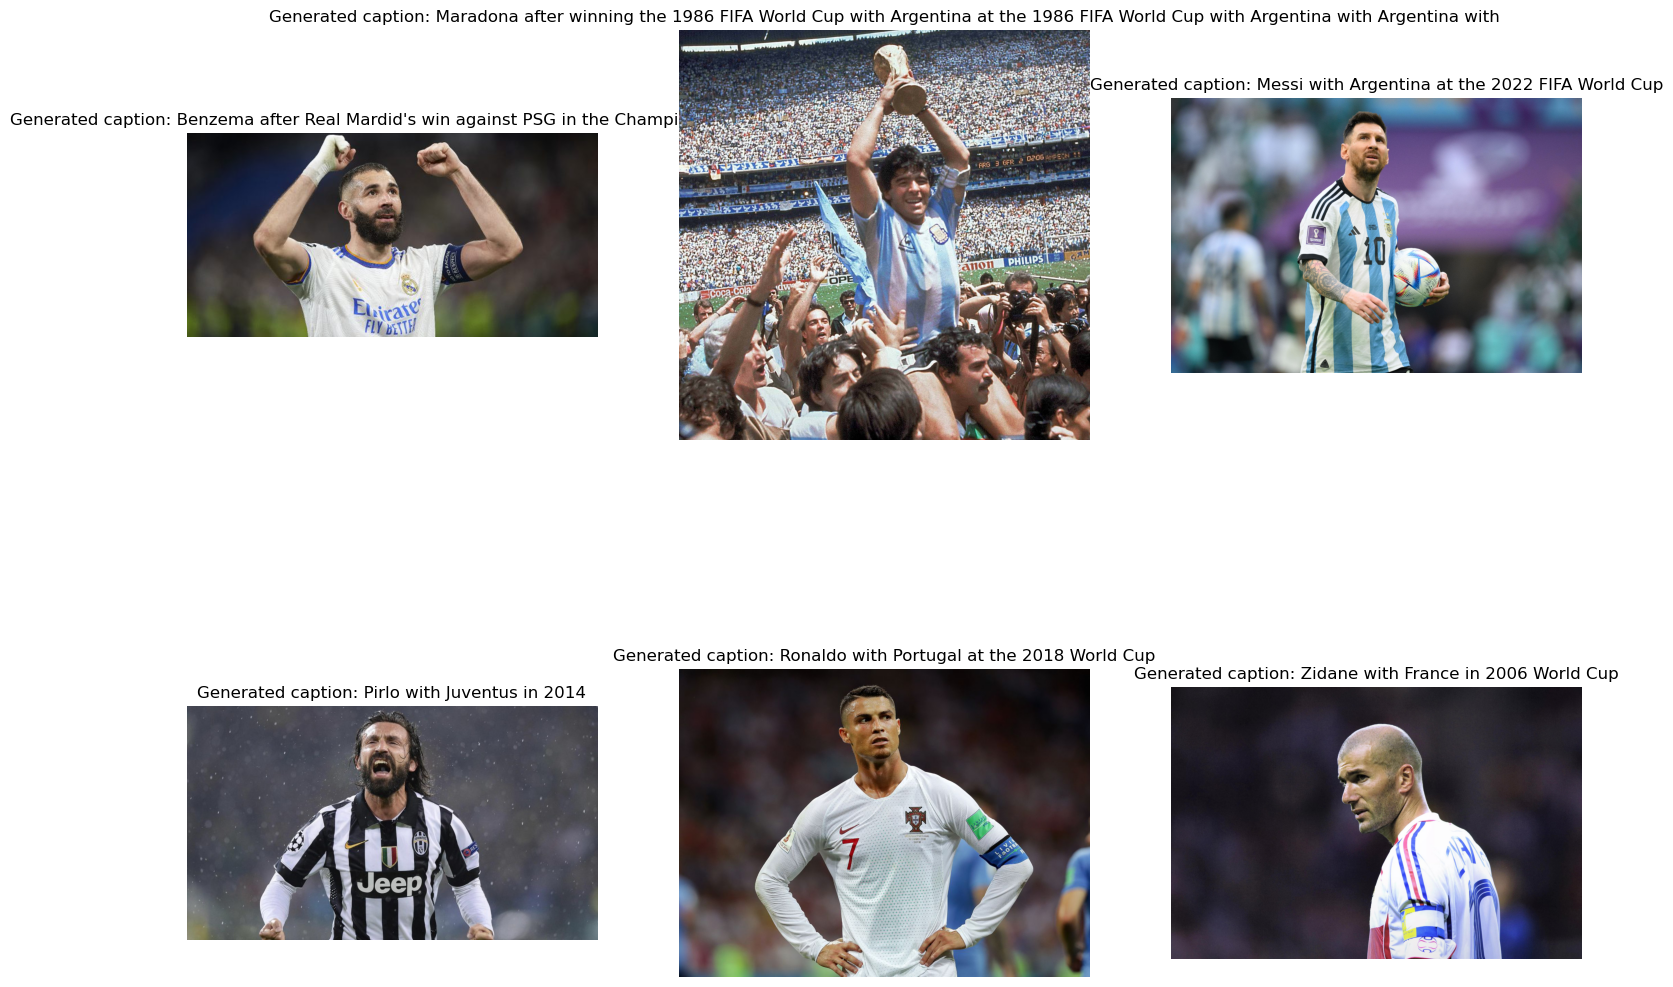

In [13]:
import torch
from matplotlib import pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

fig = plt.figure(figsize=(18, 14))

# prepare image for the model
for i, example in enumerate(dataset):
  image = example["image"]
  inputs = processor(images=image, return_tensors="pt").to(device, torch.float16)
  pixel_values = inputs.pixel_values

  generated_ids = model.generate(pixel_values=pixel_values, max_length=25)
  generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
  fig.add_subplot(2, 3, i+1)
  plt.imshow(image)
  plt.axis("off")
  plt.title(f"Generated caption: {generated_caption}")